# Проект по курсу "Открытые данные"
### Автор: Даниил Вишнев
Цель проекта: исследовать, как цены на авиабилеты зависят от времени, оставшегося до вылета.

In [494]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
%matplotlib inline

In [495]:
aviasales_url = 'http://api.travelpayouts.com/v2/prices/latest'

In [496]:
###### Функция get_data выдает параметры рейсов, хранящихся в кэше поисковых запросов 
###### сервиса Aviasales.ru, используя соответствующий API
### Параметры:
### origin -- строка с IATA кодом города отправления
### destination -- строка с IATA кодом города прибытия
### period_type -- принимает значения 'year', 'month' выполняет поиск за все время или последний месяц соответственно
### one_way -- принимает значения True, False для поиска билетов в одну сторону или в обе
### trip_class -- принимает значения 0, 1, 2 для поиска билетов класса эконом, бизнес, первый 
### page -- номер страницы выдачи
### limit -- число записей на странице

### Поскольку поиск происходит по кэшу, гарантировать, что код будет работать стабильно, нет возможности. 

def get_data(origin='MOW', 
             destination='LED', 
             period_type='year',
             one_way='true',
             trip_class=0,
             page=1,
             limit=1000):
    
    # Проверяем, что города с такими кодами существуют
    for code in [origin, destination]:
        r = requests.get('https://iatacodes.org/api/v6/cities', 
                     {'api_key':'01772a0c-87c1-4a42-9d4b-3ecd74477c37', 'code':code})
        if len(r.json()['response']) == 0:
            raise Exception("No city has IATA code {}.".format(code))
            
    # Запрашиваем данные
    token = YOUR_TOKEN
    r = requests.get(aviasales_url, {'origin':origin, 
                                 'destination':destination, 
                                 'period_type':period_type,
                                 'limit':limit,
                                 'one_way':one_way,
                                 'trip_class':trip_class,
                                 'sorting':'price',
                                 'token':token})

    data = r.json()
    
    # Обрабатываем ошибки
    if 'message' in data:
        raise Exception(data['message'])
        
    if not data['success'] or len(data['data']) == 0:
        print("NB: For some reason no flights were found.")
        return
        
    df = pd.DataFrame(data['data'])
        
    # Добавляем в датафрейм колонку с временем до вылета
    t_departure = pd.DataFrame()
    t_departure['year'] = df['depart_date'].apply(lambda x: int(x[0:4]))
    t_departure['month'] = df['depart_date'].apply(lambda x: int(x[5:7]))
    t_departure['day'] = df['depart_date'].apply(lambda x: int(x[8:10]))
    t_departure['date'] = t_departure.apply(lambda x: datetime.date(year=x['year'],
                                                                    month=x['month'],
                                                                    day=x['day']),
                                            axis=1)
    t_found = pd.DataFrame()
    t_found['year'] = df['found_at'].apply(lambda x: int(x[0:4]))
    t_found['month'] = df['found_at'].apply(lambda x: int(x[5:7]))
    t_found['day'] = df['found_at'].apply(lambda x: int(x[8:10]))
    t_found['date'] = t_found.apply(lambda x: datetime.date(year=x['year'],
                                                                    month=x['month'], 
                                                                    day=x['day']),
                                    axis=1)  
    
    df['time_to_departure'] = (t_departure['date'] - t_found['date']).apply(lambda x: x.days)
    
    # Возвращаем датафрейм
    return df

Кажется, что билеты, купленные заранее, должны быть дешевле билетов, купеленных в день вылета. 
# Глава 1 (где он долго и нудно строил всякие графики)
Давайте проверим нашу гипотезу, посмотрев на цены рейсов по маршруту Москва &mdash; Нью-Йорк.

/Users/dvishnev/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


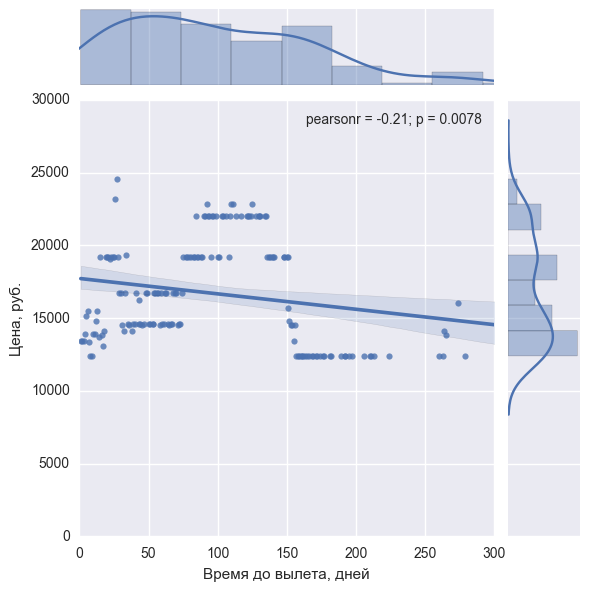

In [497]:
df = get_data(origin='MOW', destination='NYC')
plot = sns.jointplot(data=df, x='time_to_departure', y='value', truncate=True, 
                     xlim=(0, 300), ylim=(0, 30000), kind='reg')
plot.set_axis_labels('Время до вылета, дней', 'Цена, руб.')
plt.show()

В среднем наше предположение верно, но картинка выглядит не слишком убедительно &mdash; данные группируются в кластеры и плохо приближаются линейной зависимостью.

Хмм, в Нью-Йорк из Москвы можно лететь с пересадками. Давайте попробуем проконтролировать на число пересадок.

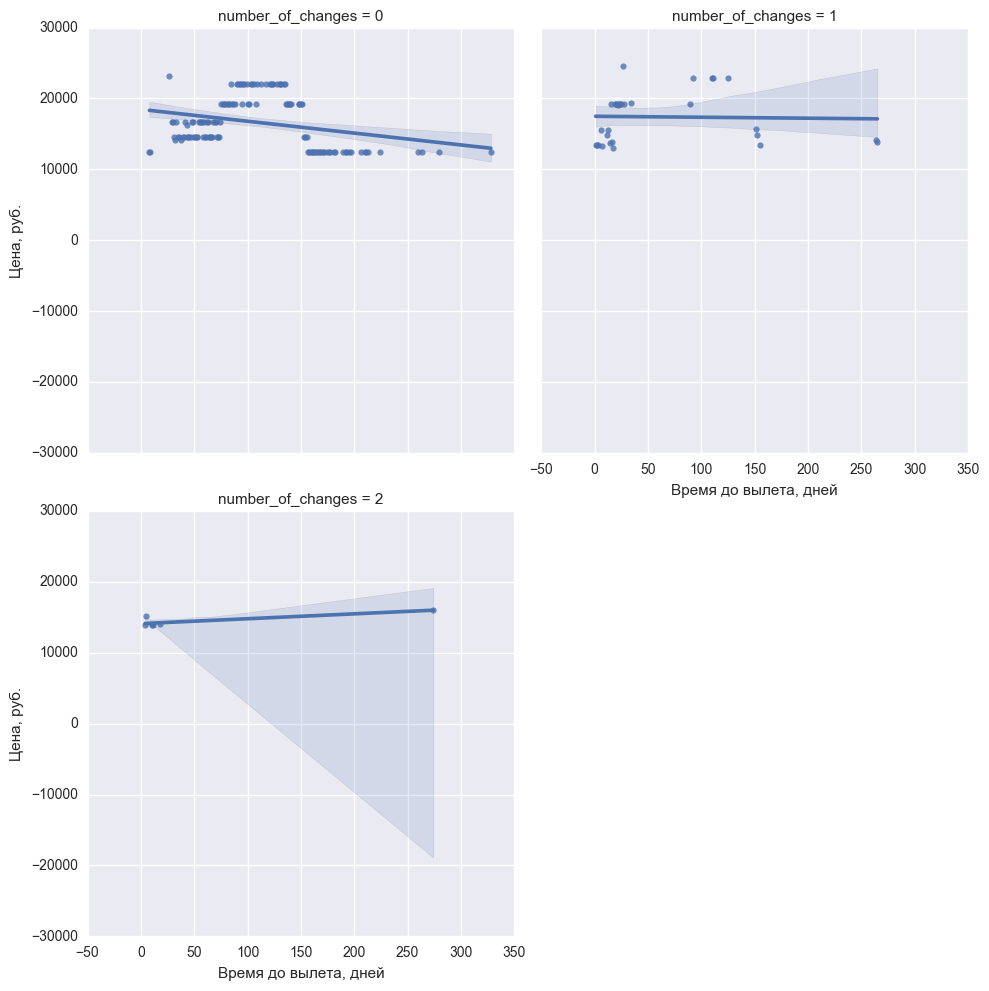

In [498]:
plot = sns.lmplot(data=df, x='time_to_departure', y='value', truncate=True, col='number_of_changes', col_wrap=2)
plot.set_axis_labels('Время до вылета, дней', 'Цена, руб.')
plt.show()

Рейсов с двумя пересадками мало, не будем на них больше смотреть.

In [499]:
nonstop = df[df['number_of_changes']==0]
one_stop = df[df['number_of_changes']==1]

/Users/dvishnev/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


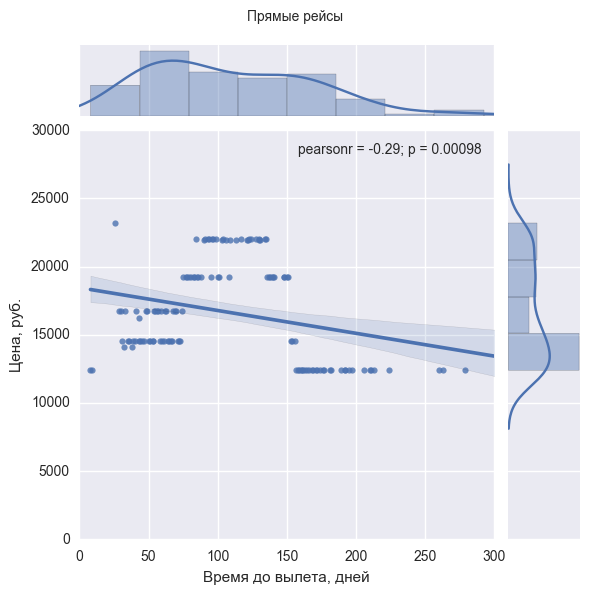

In [500]:
plot = sns.jointplot(data=nonstop, x='time_to_departure', y='value', truncate=True, 
                     xlim=(0, 300), ylim=(0, 30000), kind='reg')
plot.set_axis_labels('Время до вылета, дней', 'Цена, руб.')
plt.subplots_adjust(top=0.92)
sns.plt.suptitle('Прямые рейсы')
plt.show()

Эффект совсем не линейный, давайте приблизим зависимость параболой.

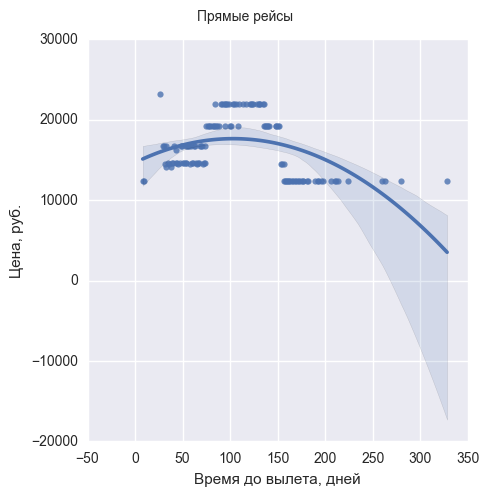

In [501]:
plot = sns.lmplot(data=nonstop, x='time_to_departure', y='value', truncate=True, order=2)
plot.set_axis_labels('Время до вылета, дней', 'Цена, руб.')
plt.subplots_adjust(top=0.92)
sns.plt.suptitle('Прямые рейсы')
plt.show()

Уже лучше!

Если посмотреть еще внимательнее, станет понятно что примерно на отметке 150 дней что-то происходит и зависимость меняет характер (цены после 150 почти совсем одинаковые). Давайте посмотрим на участок до 150.

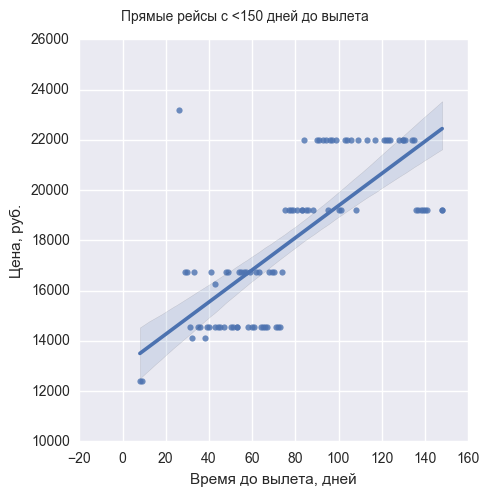

In [502]:
plot = sns.lmplot(data=nonstop[nonstop['time_to_departure'] < 150], x='time_to_departure', y='value', truncate=True, order=1)
plot.set_axis_labels('Время до вылета, дней', 'Цена, руб.')
plt.subplots_adjust(top=0.92)
sns.plt.suptitle('Прямые рейсы с <150 дней до вылета')
plt.show()

В этот раз зависимость выглядит довольно убедительно. И мы видим, что чем ближе вылет &mdash; тем дешевле билеты!

А что там у нас с полетами с пересадкой?

/Users/dvishnev/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


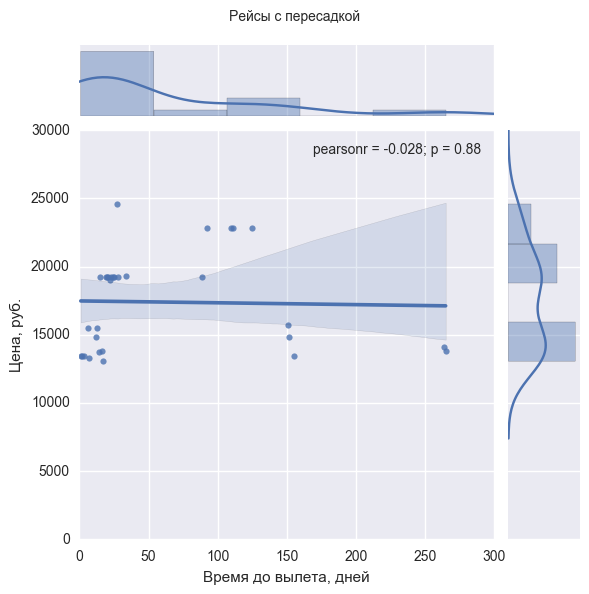

In [503]:
plot = sns.jointplot(data=one_stop, x='time_to_departure', y='value', truncate=True, 
                     xlim=(0, 300), ylim=(0, 30000), kind='reg')
plot.set_axis_labels('Время до вылета, дней', 'Цена, руб.')
plt.subplots_adjust(top=0.92)
sns.plt.suptitle('Рейсы c пересадкой')
plt.show()

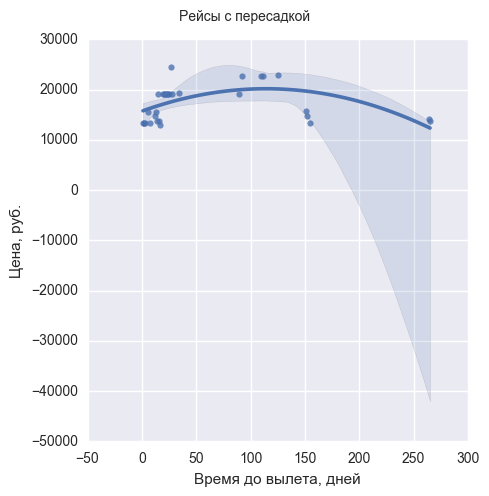

In [504]:
plot = sns.lmplot(data=one_stop, x='time_to_departure', y='value', truncate=True, order=2)
plot.set_axis_labels('Время до вылета, дней', 'Цена, руб.')
plt.subplots_adjust(top=0.92)
sns.plt.suptitle('Рейсы c пересадкой')
plt.show()

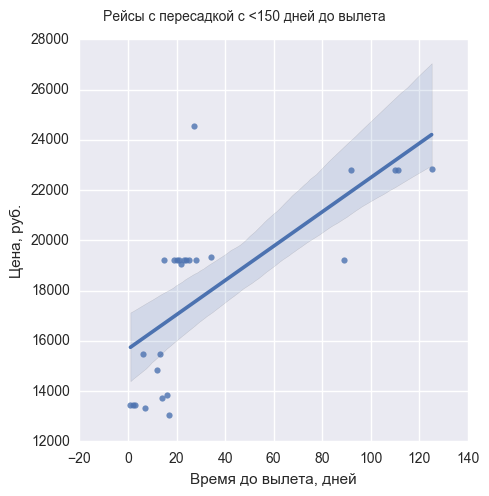

In [505]:
plot = sns.lmplot(data=one_stop[one_stop['time_to_departure'] < 150], x='time_to_departure', y='value', truncate=True, order=1)
plot.set_axis_labels('Время до вылета, дней', 'Цена, руб.')
plt.subplots_adjust(top=0.92)
sns.plt.suptitle('Рейсы с пересадкой с <150 дней до вылета')
plt.show()

В целом похоже!

А на обратном пути все так же?

/Users/dvishnev/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


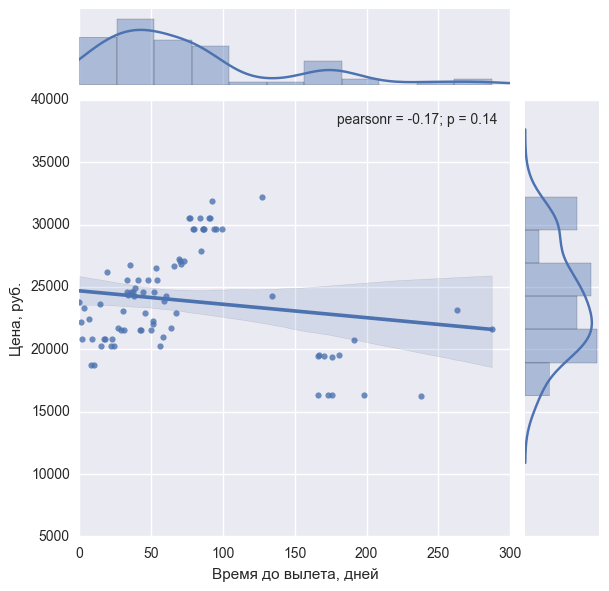

In [506]:
df = get_data(origin='NYC', destination='MOW')
plot = sns.jointplot(data=df, x='time_to_departure', y='value', truncate=True, 
                     xlim=(0, 300), kind='reg')
plot.set_axis_labels('Время до вылета, дней', 'Цена, руб.')
plt.show()

Сесть на верблюда можно и бесплатно. А вот слезать &mdash; уже за деньги. Иначе говоря, обратно лететь дороже, хотя взаимосвязь похожа.

# Глава 2 (где он на минуту размечтался)

А если мы посмотрим на бизнес-класс, найдем ли мы что-то похожее?

In [507]:
df = get_data(origin='MOW', destination='NYC', trip_class=1)
nonstop = df[df['number_of_stops']==0]
plot = sns.jointplot(data=nonstop, x='time_to_departure', y='value', truncate=True, 
                     kind='reg')
plot.set_axis_labels('Время до вылета, дней', 'Цена, руб.')
plt.show()

NB: For some reason no flights were found.


TypeError: 'NoneType' object is not subscriptable

Непонятно... Неужели я один хочу полететь бизнес-классом в Нью-Йорк и билеты больше никто не искал (данные же из кэша поиска)?!

# Глава 3 (где он искал что-нибудь себе по карману)

Ладно, на Нью-Йорк посмотрели, давайте на что-нибудь более патриотичное посмотрим. Может в Питер на выходные?

/Users/dvishnev/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


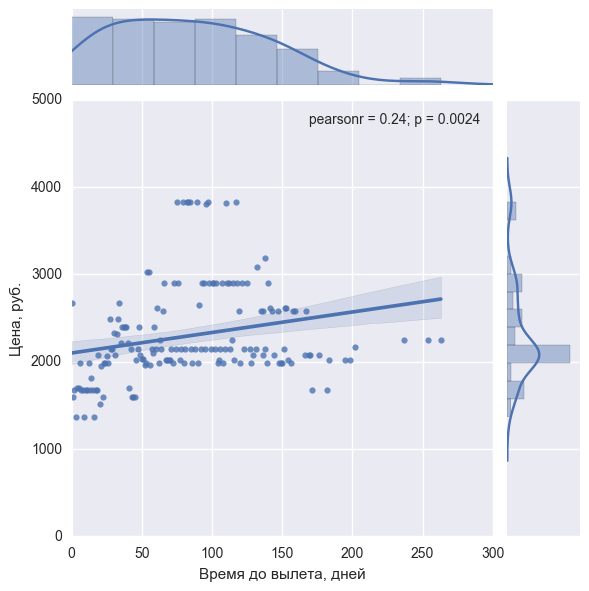

In [509]:
df = get_data(origin='MOW', destination='LED')
plot = sns.jointplot(data=df, x='time_to_departure', y='value', truncate=True, 
                     xlim=(0, 300), ylim=(0, 5000), kind='reg')
plot.set_axis_labels('Время до вылета, дней', 'Цена, руб.')
plt.show()

Здесь мы сразу видим возрастающую линию. Причем самые дешевые билеты за все время можно купить буквально в день вылета. Хотя здесь может играть роль сезонность.

/Users/dvishnev/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


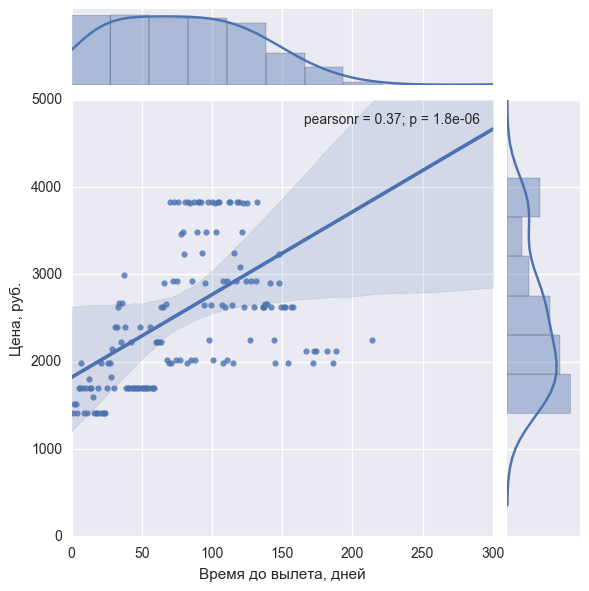

In [510]:
df = get_data(origin='LED', destination='MOW')
plot = sns.jointplot(data=df, x='time_to_departure', y='value', truncate=True, 
                     xlim=(0, 300), ylim=(0, 5000), kind='reg')
plot.set_axis_labels('Время до вылета, дней', 'Цена, руб.')
plt.show()

На обратном пути все аналогично.

# Глава 4 (где он решил скачать Интернет)

Смотреть на отдельные города &mdash; это, конечно, хорошо. А что если мы соберем данные по 9 самым загруженным аэропортам мира и добавим Москву? Останется ли тогда взаимосвязь?

In [511]:
# Скачаем из Википедии IATA-коды 9 самых загруженных аэропортов мира
n = 9
url = 'https://en.wikipedia.org/wiki/List_of_busiest_airports_by_passenger_traffic'
r = requests.get(url)
page = BeautifulSoup(r.text, 'html.parser')
airport_iata_codes = []
for i in range(4, 4 + 8 * (n - 1), 8):
    codes = page('table')[0]('td')[i]
    airport_iata_codes += codes
airport_iata_codes = [str(code)[0:3] for code in airport_iata_codes]

In [512]:
airport_iata_codes

['ATL', 'PEK', 'DXB', 'LAX', 'HND', 'ORD', 'LHR', 'HKG']

К сожалению восстановление IATA-кода города по IATA-коду аэропорта входит в платный премиум-пакет API сайта, где я искал коды, а Википедия не сообщает IATA-код на странице города. Придется сделать по-другому.

In [513]:
# Скачаем список аэропортов мира с их параметрами
r = requests.get('http://api.travelpayouts.com/data/airports.json')
data = r.json()

# Отберем только те аэропорты, что нас интересуют и получим коды их городов
data = [airport for airport in data if (airport['code'] in airport_iata_codes)]
cities_iata_codes = [airport['city_code'] for airport in data]
cities_iata_codes

['CHI', 'DXB', 'HKG', 'LON', 'ATL', 'BJS', 'LAX', 'TYO']

Добавим Москву.

In [514]:
cities_iata_codes.append('MOW')
cities_iata_codes

['CHI', 'DXB', 'HKG', 'LON', 'ATL', 'BJS', 'LAX', 'TYO', 'MOW']

In [515]:
# Добавим к нашим данным по маршруту LED-MOW еще немного записей
for org in cities_iata_codes:
    for des in cities_iata_codes:
        if org != des:
            df = df.append(get_data(origin=org, destination=des), ignore_index=True)

NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For some reason no flights were found.
NB: For som

К сожалению, мы нашли рейсы не по всем маршрутам (наверное, лучше было использовать api англоязычного сервиса, например, Expedia). Но все не так плохо, ведь в сумме мы совершили 90 запросов. Давайте посмотрим, все ли в порядке и сколько у нас данных.

In [516]:
df.head()

,actual,depart_date,destination,distance,found_at,number_of_changes,origin,return_date,show_to_affiliates,trip_class,value,time_to_departure
0,True,2017-04-20,MOW,634,2017-04-02T23:41:07+04:00,0,LED,,True,0,1408,18
1,True,2017-04-03,MOW,634,2017-04-02T23:43:24+04:00,0,LED,,True,0,1413,1
2,True,2017-04-06,MOW,634,2017-04-02T23:35:39+04:00,0,LED,,True,0,1414,4
3,True,2017-04-18,MOW,634,2017-04-02T23:41:09+04:00,0,LED,,True,0,1414,16
4,True,2017-04-25,MOW,634,2017-04-02T22:28:18+04:00,0,LED,,True,0,1414,23


In [517]:
df.tail()

,actual,depart_date,destination,distance,found_at,number_of_changes,origin,return_date,show_to_affiliates,trip_class,value,time_to_departure
1126,True,2017-04-05,TYO,7480,2017-04-02T20:52:15+04:00,2,MOW,,True,0,24694,3
1127,True,2017-08-12,TYO,7480,2017-04-02T13:08:38+04:00,1,MOW,,True,0,24746,132
1128,True,2017-04-28,TYO,7480,2017-04-02T18:34:33+04:00,2,MOW,,True,0,25004,26
1129,True,2017-05-05,TYO,7480,2017-04-01T21:52:47+04:00,1,MOW,,True,0,26728,34
1130,True,2017-05-06,TYO,7480,2017-04-01T21:46:18+04:00,2,MOW,,True,0,32319,35


In [518]:
df.shape

(1131, 12)

Наблюдений получилось не так уж много. Ну давайте посмотрим на то, что есть. Для сравнимости будем смотреть на цену за километр.

In [519]:
df['value_per_distance'] = df['value'] / df['distance']

/Users/dvishnev/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


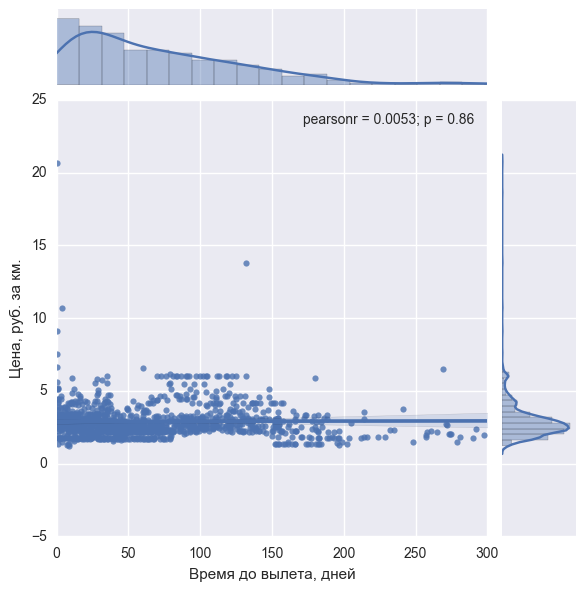

In [520]:
plot = sns.jointplot(data=df, x='time_to_departure', y='value_per_distance', truncate=True, 
                     xlim=(0, 300), kind='reg')
plot.set_axis_labels('Время до вылета, дней', 'Цена, руб. за км.')
plt.show()

In [521]:
reg = sm.ols(formula="value_per_distance ~ time_to_departure", data=df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     value_per_distance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03200
Date:                Sun, 02 Apr 2017   Prob (F-statistic):              0.858
Time:                        22:48:30   Log-Likelihood:                -1897.6
No. Observations:                1131   AIC:                             3799.
Df Residuals:                    1129   BIC:                             3809.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             2.8989      0.060     48.667      0.000         2.782     3.016
time_to_departure     0.0001      0.001      0.179      0.858        -0.001     0.001
==============================================================================
Omnibus:                     1243.042   Durbin-Watson:                   0.635
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           145188.926
Skew:                           5.171   Prob(JB):                         0.00
Kurtosis:                      57.534   Cond. No.                         149.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Вот так всегда: исследуешь, как A влияет на Б, исследуешь, графики строишь. А в итоге &mdash; никак не влияет.

Давайте ради любопытства посмотрим на цены с совсем скорым вылетом.

/Users/dvishnev/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


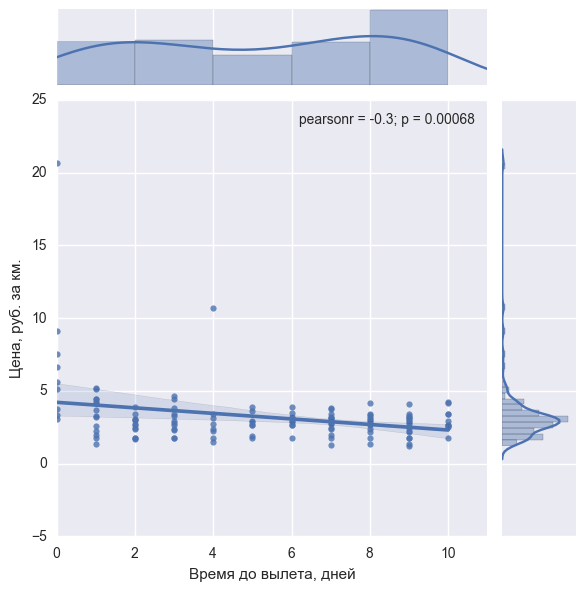

In [522]:
df_trimmed = df[df['time_to_departure']<11]

plot = sns.jointplot(data=df_trimmed, x='time_to_departure', y='value_per_distance', truncate=True, 
                     xlim=(0, 11), kind='reg')
plot.set_axis_labels('Время до вылета, дней', 'Цена, руб. за км.')
plt.show()

In [523]:
reg = sm.ols(formula="value_per_distance ~ time_to_departure", data=df_trimmed).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     value_per_distance   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     12.15
Date:                Sun, 02 Apr 2017   Prob (F-statistic):           0.000680
Time:                        22:48:44   Log-Likelihood:                -263.71
No. Observations:                 126   AIC:                             531.4
Df Residuals:                     124   BIC:                             537.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             4.2104      0.334     12.602      0.000         3.549     4.872
time_to_departure    -0.1903      0.055     -3.485      0.001        -0.298    -0.082
==============================================================================
Omnibus:                      172.586   Durbin-Watson:                   1.250
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8246.810
Skew:                           5.138   Prob(JB):                         0.00
Kurtosis:                      41.278   Cond. No.                         11.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Все же в среднем лучше вылетать завтра, чем сегодня. Да сегодня уже и не хочется.

# Глава 5 (где он долго оправдывался)

В заключении я бы хотел написать пару слов о том, почему вопрос, на который я пытался ответить, не совсем бессмысленный. 

В теории можно придумать разннонаправленные эффекты времени до вылета на цену. Представим, что пассажир хочет купить билет за два часа до вылета, а у авиакомпании на рейсе остались свободные места.

С одной стороны, авиакомпания вряд ли продаст еще много билетов до вылета. При этом издержки на перелет почти не зависят от того, полетит дополнительный пассажир или нет. Тогда, почти вся стоимость билета будет выгодой компании от продажи. Поэтому цена может быть небольшой, особенно если рейсов по данному направлению много и пассажир может полететь рейсом через 3 часа, через 4, через 5 еще десятью другими авиакомпаниями.

С другой стороны, типичный пассажир не хочет никуда лететь через два часа. Вероятно те, кто покупают билет на ближайшую дату, очень спешат по каким-то причинам и наверняка готовы заплатить побольше. Особенно сильно этот эффект должен проявляться, если альтернатив у пассажира немного. Также авиакомпания может специально не продавать дешевые бидеты перед вылетом, чтобы стратегические пассажиры не начали тянуть с покупкой до последнего.

В своем "исследовании" я все время гнал регрессию цены на время до отлета и почти не заботился о том, что рейсы вообще-то отличаются. В то же время, в типичном экономическом исследовании регрессия включает десятки контрольных переменных. Значит ли это, что все написанное выше совсем бессмыслица? Вот здесь обнаруживается удивительное. Понятно, что я не включил в регрессию все переменные, определяющие цену билета. Но это и не нужно. Дело в том, в среднем коэффициент при переменной в линейной регрессии будет смещенным только если мы не включили переменную, определяющую цену, а также скоррелированную с временем до вылета. Обычно таких переменных можно придумать множество. Но время до вылета обладает удивительным свойством &mdash; с ним не так просто рассказать историю про Omitted Variable Bias (OVB). Действительно, может из Москвы все билеты дороже в 5 раз, чем из Токио, но город не коррелирует с временем до вылета. Может билеты Аэрофлота в 100 раз дороже билетов EasyJet, но время до вылета не зависит от авиакомпании. Таможенные пошлины и аэропортовые сборы тоже не зависят от времени до вылета. Редко в прикладной эконометрике встретишь такую переменную.

Но, конечно, не все так совсем уж радужно. Можно себе представить, что цены на билеты не меняются с временем до вылета, но разные у разных авиакомпаний. Если дешевые билеты разбирают заранее &mdash; получится, что авиакомпания все-таки коррелирует с временем до вылета и определяет цену, а значит делает нашу оценку смещенной.

Как-то так.

P.S. Если придумаю интересный экономический вопрос, на который получится ответить, &mdash; напишу об этом диплом. Уж очень я люблю летать :) 